# Exact Simulator for Synthetic data

In [1]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn

#### Class for parameters

In [2]:
class params:
    def __init__(self, seed=42):
        self.seed = seed
        self.l = 5
        self.T = 21
        self.T0 = 11
        self.K = 5
        self.N = 200000
        self.M = 5000
        self.z_dim = 5
        self.I = 3

In [3]:
class cp_params:
    def __init__(self, seed=42):
        self.seed = seed
        self.l = 5
        self.T = 21
        self.T0 = 11
        self.K = 5
        self.N = 200000
        self.M = 20000
        self.z_dim = 5
        self.I = 3

#### Function for reproducibility

In [4]:
# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

#### Simulate W parameters

In [5]:
def simulate_W(num_intervention, num_latent):
    # W_1d = np.random.normal(0, 1, size=(num_intervention, num_latent))
    # W_2d = np.random.normal(0, 1, size=(num_intervention, num_latent))
    # W_3d = np.random.normal(1, 1, size=(num_intervention, num_latent))
    W_1d = np.zeros((num_intervention, num_latent))
    W_2d = np.zeros((num_intervention, num_latent))
    W_3d = np.zeros((num_intervention, num_latent))

    m = (num_latent -1) // 2  + 1

    W_1d[:m] = np.random.uniform(1, 2, size=(num_intervention, num_latent))[:m]
    W_1d[m:] = np.random.uniform(-2, -1, size=(num_intervention, num_latent))[m:]

    W_2d[:m] = np.random.uniform(1, 2, size=(num_intervention, num_latent))[:m]
    W_2d[m:] = np.random.uniform(-2, -1, size=(num_intervention, num_latent))[m:]

    W_3d[:m] = np.random.uniform(2, 3, size=(num_intervention, num_latent))[:m]
    W_3d[m:] = np.random.uniform(-1, 0, size=(num_intervention, num_latent))[m:]

    W_1d[0] = 0
    W_2d[0] = 0
    W_3d[0] = 1

    print(W_1d)
    print(W_2d)
    print(W_3d)
    return W_1d, W_2d, W_3d


### Simulate D train and test

In [6]:
def simulate_D_train(num_intervention, num_individuals, T0, T, max_interventions):
    D = np.zeros((num_individuals, T))
    # max_interventions = num_intervention // 2 + 1
    d_k = np.stack([np.random.choice(num_intervention, max_interventions, replace=False) for i in range(num_individuals)]) 
    d_t = np.stack([np.random.choice(T-T0, max_interventions, replace=False) for i in range(num_individuals)]) 
    for i in range(num_individuals):
        D[i, d_t[i] + T0] = d_k[i]
    for i in range(num_intervention):
        for t in range(T):
            if D[i, t] > 0:
                if t + 1 < T:
                    D[i, t + 1] = 0
                if t + 2 < T:
                    D[i, t + 2] = 0
                if t + 3 < T:
                    D[i, t + 3] = 0

    D[:, -1] = 0

    return D

In [7]:
def simulate_D_test(num_intervention, num_individuals, T0, T, max_interventions):
    T = T + 5
    D = np.zeros((num_individuals, T))
    # max_interventions = num_intervention // 2 + 1
    d_k = np.stack([np.random.choice(num_intervention, max_interventions, replace=False) for i in range(num_individuals)]) 
    d_t = np.stack([np.random.choice(T-T0-5, max_interventions, replace=False) for i in range(num_individuals)]) 
    d_t_ = np.zeros((num_individuals, 1))
    for i in range(num_individuals):
        available_options = set(range(num_intervention)) - set(d_k[i]) - set([0])
        d_t_[i] = np.random.choice(list(available_options), 1, replace=False)
    for i in range(num_individuals):
        D[i, d_t[i] + T0] = d_k[i]
        D[i, T-5] = d_t_[i]
    for i in range(num_intervention):
        for t in range(T-5):
            if D[i, t] > 0:
                if t + 1 < T-5:
                    D[i, t + 1] = 0
                if t + 2 < T-5:
                    D[i, t + 2] = 0
                if t + 3 < T-5:
                    D[i, t + 3] = 0

    D[:, -6] = 0

    return D

#### Functions for psi

In [8]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def psi(d_t_prime, w_1d, w_2d, w_3d, t, t_prime):
    return (sigmoid(w_1d[d_t_prime])**(t-t_prime)) * w_2d[d_t_prime] + w_3d[d_t_prime]

def psi_product(d_n, w_1d, w_2d, w_3d):
    N, T = d_n.shape
    _, l = w_1d.shape
    d_n_l = np.ones((N, T, l))
    for t in range(T):
        for t_prime in range(t):
            d_n_t_prime = d_n[:, t_prime]
            psi_ = psi(d_n_t_prime.astype(int), w_1d, w_2d, w_3d, t, t_prime)
            d_n_l[:, t, :] = psi_ * d_n_l[:, t, :]

    return d_n_l    

#### Functions for beta

In [9]:
def simulate_beta(num_individuals, num_latent):
    mu = np.random.normal(0, 1, size=(num_individuals, num_latent))
    sigma = np.exp(np.random.normal(0, 1, size=(num_individuals, num_latent)))
    beta = np.random.normal(mu, sigma)
    return beta

#### Functions for covaraite Z

### Create user specific covariate Z

In [10]:
def simulate_z(num_individuals, z_dim):
    Z = np.random.normal(0, 3, size=(2*num_individuals, z_dim))
    W1_z = np.random.randn(z_dim, z_dim)
    b1_z = np.random.randn(z_dim)
    W2_z = np.random.randn(z_dim, 1)
    b2_z = np.random.randn(1)
    X_0 = np.dot(np.maximum(0, np.dot(Z, W1_z) + b1_z), W2_z) + b2_z
    X_0 = X_0[:, 0]
    return Z, X_0  

In [11]:
class SyntheticLSTM(nn.Module):
    def __init__(self, z_dim, num_latent, num_layers=1):
        super(SyntheticLSTM, self).__init__()
        self.lstm = nn.LSTM(z_dim + 1, num_latent, num_layers, batch_first=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        final = lstm_out[:, -1, :]
        # final = self.mlp(final)
        final = self.sigmoid(final)
        return final
  

In [12]:
def simulate_x_train(num_individual, T, X_0, lstm_model, beta, psi, Z):
    X_full = np.zeros((num_individual, T+1))
    X_full_0 = np.zeros((num_individual, T+1))
    X_full[:, 0] = X_0
    X_full_0[:, 0] = X_0 
    X_noise = np.random.normal(0, 1, size=(num_individual, T))

    beta_ = np.tile(beta[:, np.newaxis, :], (1, T, 1))

    with torch.no_grad():
        for t in range(T):
            input_x = X_full[:, :t+1][:, :, np.newaxis]
            input_x_0 = X_full_0[:, :t+1][:, :, np.newaxis]
            Z_ = np.tile(Z[:, np.newaxis, :], (1, input_x.shape[1], 1))
            input_seq = np.concatenate((input_x, Z_), axis=2)
            input_seq_0 = np.concatenate((input_x_0, Z_), axis=2)
            phi = lstm_model(torch.from_numpy(input_seq).float()).detach().cpu().numpy()
            phi_0 = lstm_model(torch.from_numpy(input_seq_0).float()).detach().cpu().numpy()
            x_t = np.sum(phi * beta_[:, t, :]*psi[:, t, :], axis=-1) + X_noise[:, t]
            x_t_0 = np.sum(phi_0 * beta_[:, t, :], axis=-1) + X_noise[:, t]
            X_full[:, t+1] = x_t
            X_full_0[:, t+1] = x_t_0
    
    X_final = X_full[:, 1:]
    X_final_0 = X_full_0[:, 1:]
    return X_final, X_final_0

In [13]:
def simulate_x_test(num_individual, T, X_0, lstm_model, beta, psi, Z, num_samples=50):
    X_full = np.zeros((num_individual, T+1+5, num_samples))
    X_full[:, 0, 0] = X_0
    X_full_0 = np.zeros((num_individual, T+1+5, num_samples))
    X_full_0[:, 0, 0] = X_0
    X_noise = np.random.normal(0, 1, size=(num_individual, T+5, num_samples))

    beta_ = np.tile(beta[:, np.newaxis, :], (1, T+5, 1))
    Z_ = np.tile(Z[:, np.newaxis, :], (1, T + 1 + 5, 1)) 


    with torch.no_grad():
        for t in range(T):
            input_x = X_full[:, :t+1, 0][:, :, np.newaxis]
            input_x_0 = X_full_0[:, :t+1, 0][:, :, np.newaxis]
            # Z_ = np.tile(Z[:, np.newaxis, :], (1, input_x.shape[1], 1))
            input_seq = np.concatenate((input_x, Z_[:, :t+1, :]), axis=2)
            input_seq_0 = np.concatenate((input_x_0, Z_[:, :t+1, :]), axis=2)
            phi = lstm_model(torch.from_numpy(input_seq).float()).detach().cpu().numpy()
            phi_0 = lstm_model(torch.from_numpy(input_seq_0).float()).detach().cpu().numpy()
            x_t = np.sum(phi * beta_[:, t, :]*psi[:, t, :], axis=-1) + X_noise[:, t, 0]
            x_t_0 = np.sum(phi_0 * beta_[:, t, :], axis=-1) + X_noise[:, t, 0]
            X_full[:, t+1, 0] = x_t
            X_full_0[:, t+1, 0] = x_t_0
        
        X_full[:, :T+1] = np.tile(X_full[:, :T+1, 0][:, :, np.newaxis], (1, 1, num_samples))
        X_full_0[:, :T+1] = np.tile(X_full_0[:, :T+1, 0][:, :, np.newaxis], (1, 1, num_samples))

        for t in range(T, T+5):
            # print(f'put at position {t+1}, which is the {t} th')
            for j in range(num_samples):
                input_x = X_full[:, :t+1, j][:, :, np.newaxis]
                input_x_0 = X_full_0[:, :t+1, j][:, :, np.newaxis]
                input_seq = np.concatenate((input_x, Z_[:, :t+1, :]), axis=2)
                input_seq_0 = np.concatenate((input_x_0, Z_[:, :t+1, :]), axis=2)
                phi = lstm_model(torch.from_numpy(input_seq).float()).detach().cpu().numpy()
                phi_0 = lstm_model(torch.from_numpy(input_seq_0).float()).detach().cpu().numpy()
                x_t = np.sum(phi * beta_[:, t, :]*psi[:, t, :], axis=-1) + X_noise[:, t, j]
                x_t_0 = np.sum(phi_0 * beta_[:, t, :], axis=-1) + X_noise[:, t, j]
                X_full[:, t+1, j] = x_t
                X_full_0[:, t+1, j] = x_t_0
            
    X_final = X_full[:, 1:]
    X_final_0 = X_full_0[:, 1:]

    return X_final, X_final_0

In [14]:
def simulator(PARAMS):

    set_seed(PARAMS.seed)
    W_1d, W_2d, W_3d = simulate_W(PARAMS.K, PARAMS.l)
    D_train = simulate_D_train(PARAMS.K, PARAMS.N, PARAMS.T0, PARAMS.T, PARAMS.I)
    D_test = simulate_D_test(PARAMS.K, PARAMS.M, PARAMS.T0, PARAMS.T, PARAMS.I)
    psi_train = psi_product(D_train, W_1d, W_2d, W_3d)
    psi_test = psi_product(D_test, W_1d, W_2d, W_3d)
    beta_train = simulate_beta(PARAMS.N, PARAMS.l)
    beta_test = simulate_beta(PARAMS.M, PARAMS.l)
    Z, X0 = simulate_z(PARAMS.N, PARAMS.z_dim)
    Z_train, Z_test = Z[:PARAMS.N, :], Z[PARAMS.N:PARAMS.N+PARAMS.M, :]
    X0_train, X0_test = X0[:PARAMS.N], X0[PARAMS.N:PARAMS.N+PARAMS.M]
    lstm_model = SyntheticLSTM(PARAMS.z_dim, PARAMS.l)
    X_train, X_train0 = simulate_x_train(PARAMS.N, PARAMS.T, X0_train, lstm_model, beta_train, psi_train, Z_train)
    X_test, X_test0 = simulate_x_test(PARAMS.M, PARAMS.T, X0_test, lstm_model, beta_test, psi_test, Z_test)
    
    return D_train, D_test, X_train, X_train0, X_test, X_test0, Z_train, Z_test
    


In [15]:
def save_data(D_train, D_test, X_train, X_train0, X_test, X_test0, Z_train, Z_test, PARAMS):

    print(f'D_train shape of {D_train.shape}')
    print(f'D_test shape of {D_test.shape}')

    print(f'X_train shape of {X_train.shape}')
    print(f'X_train0 shape of {X_train0.shape}')

    print(f'X_test shape of {X_test.shape}')
    print(f'X_test0 shape of {X_test0.shape}')

    print(f'Z_train shape of {Z_train.shape}')
    print(f'Z_test shape of {Z_test.shape}')

    seed = PARAMS.seed

    np.save(f'./data/d_train_{seed}.npy', D_train)
    np.save(f'./data/d_test_{seed}.npy', D_test)

    np.save(f'./data/x_train_{seed}.npy', X_train)
    np.save(f'./data/x_test_{seed}.npy', X_test)

    np.save(f'./data/x_train0_{seed}.npy', X_train0)
    np.save(f'./data/x_test0_{seed}.npy', X_test0)
    
    np.save(f'./data/z_train_{seed}.npy', Z_train)
    np.save(f'./data/z_test_{seed}.npy', Z_test)

In [16]:
for i in range(5):
    PARAMS = params(i+1)
    D_train, D_test, X_train, X_train0, X_test, X_test0, Z_train, Z_test = simulator(PARAMS)
    save_data(D_train, D_test, X_train, X_train0, X_test, X_test0, Z_train, Z_test, PARAMS)
    print(f'Generated dataset based on seed {i+1}')

# CP_PARAMS is for the conformal prediction setting
CP_PARAMS = cp_params()
D_train, D_test, X_train, X_train0, X_test, X_test0, Z_train, Z_test = simulator(CP_PARAMS)
save_data(D_train, D_test, X_train, X_train0, X_test, X_test0, Z_train, Z_test, CP_PARAMS)
print(f'Generated dataset based on seed {CP_PARAMS.seed}')

[[ 0.          0.          0.          0.          0.        ]
 [ 1.15599452  1.05808361  1.86617615  1.60111501  1.70807258]
 [ 1.02058449  1.96990985  1.83244264  1.21233911  1.18182497]
 [-1.87796177 -1.50482309 -1.96561148 -1.0906796  -1.74122002]
 [-1.33747772 -1.68828892 -1.47993198 -1.45328972 -1.81514554]]
[[ 0.          0.          0.          0.          0.        ]
 [ 1.92187424  1.0884925   1.19598286  1.04522729  1.32533033]
 [ 1.38867729  1.27134903  1.82873751  1.35675333  1.28093451]
 [-1.88040575 -1.28675521 -1.23921495 -1.4387228  -1.22903282]
 [-1.5062044  -1.47726717 -1.57245898 -1.97458087 -1.89210857]]
[[ 1.          1.          1.          1.          1.        ]
 [ 2.24929223  2.41038292  2.75555114  2.22879817  2.07697991]
 [ 2.28975145  2.16122129  2.92969765  2.80812038  2.63340376]
 [-0.03755271 -0.7482177  -0.50275149 -0.69912169 -0.71515951]
 [-0.96311305 -0.39043567 -0.49732098 -0.94852125 -0.72135354]]
D_train shape of (200000, 21)
D_test shape of (20000

In [17]:
D_train.shape

(200000, 21)

In [18]:
D_test.shape

(20000, 26)

In [19]:
X_train.shape

(200000, 21)

In [20]:
X_train0.shape

(200000, 21)

In [21]:
X_test.shape

(20000, 26, 50)

In [22]:
X_test0.shape

(20000, 26, 50)

In [23]:
Z_train.shape

(200000, 5)

In [24]:
Z_test.shape

(20000, 5)

In [25]:
X_test[0, -6, 5]

-11.678027592030382

### note that x here, the real length should -1, D is the same as x because we add a place holder there

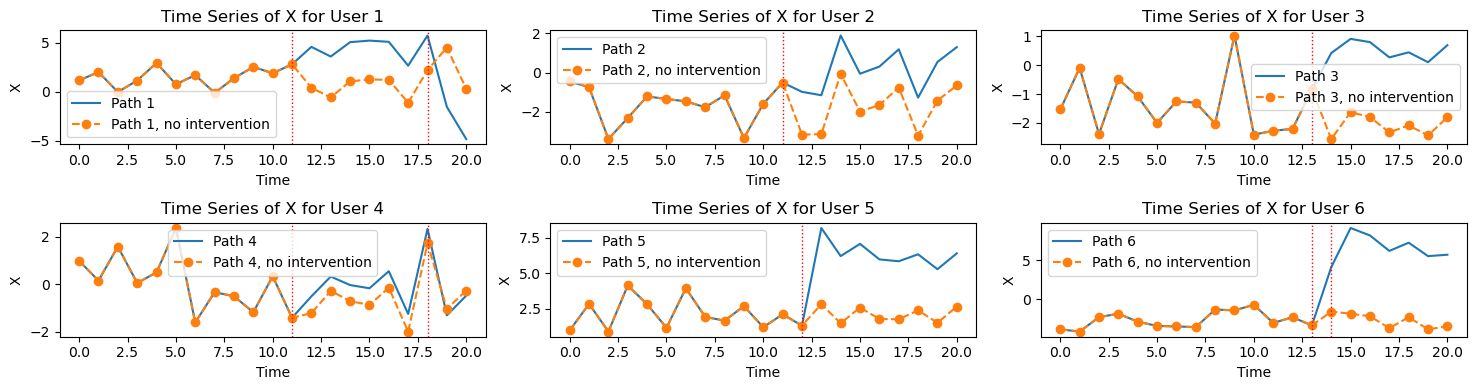

In [26]:
plt.figure(figsize=(15, 4))  # Adjust the size of the entire figure

# Ensure num_individuals is less than N
num_individuals = 6
# assert num_individuals <= N, f'Cannot plot {num_individuals} paths when N is set as {N}'

for i in range(num_individuals):
    plt.subplot(2, 3, i+1)  # Creates subplot in a 3x2 grid
    plt.plot(X_train[i, :], label=f'Path {i+1}')
    plt.plot(X_train0[i, :], label=f'Path {i+1}, no intervention', marker='o', linestyle='dashed')

    # Plot intervention points
    intervention_indices = np.where(D_train[i] != 0)[0]  # Find indices where intervention is not zero
    for idx in intervention_indices:
        plt.axvline(x=idx, color='r', linestyle=':', linewidth=1)  # Plot a vertical line at each intervention index

    plt.xlabel('Time')
    plt.ylabel('X')
    plt.title(f'Time Series of X for User {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()

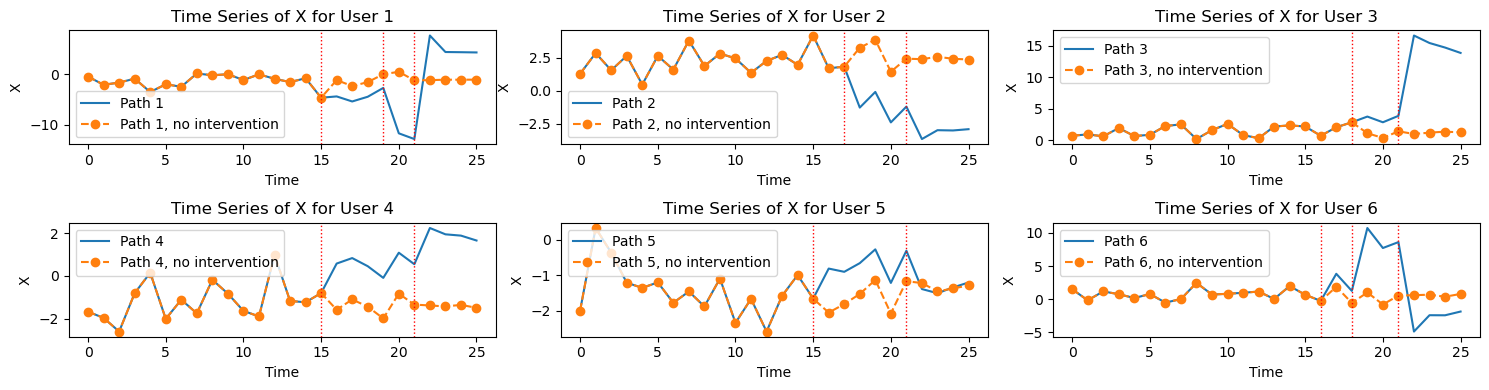

In [27]:
plt.figure(figsize=(15, 4))  # Adjust the size of the entire figure

# Ensure num_individuals is less than N
num_individuals = 6
# assert num_individuals <= N, f'Cannot plot {num_individuals} paths when N is set as {N}'

for i in range(num_individuals):
    plt.subplot(2, 3, i+1)  # Creates subplot in a 3x2 grid
    plt.plot(np.mean(X_test, axis=-1)[i, :], label=f'Path {i+1}')
    plt.plot(np.mean(X_test0, axis=-1)[i, :], label=f'Path {i+1}, no intervention', marker='o', linestyle='dashed')
    # for j in range(X_test0.shape[-1]):
        # plt.plot(X_test[i, :, j], alpha=0.1)
        # plt.plot(X_test0[i, :, j], alpha=0.1)

    # Plot intervention points
    intervention_indices = np.where(D_test[i, :] != 0)[0]  # Find indices where intervention is not zero
    for idx in intervention_indices:
        plt.axvline(x=idx, color='r', linestyle=':', linewidth=1)  # Plot a vertical line at each intervention index

    plt.xlabel('Time')
    plt.ylabel('X')
    plt.title(f'Time Series of X for User {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()